In [6]:
from flight_controller import FlightController
import pygame
import numpy as np

pygame 2.5.2 (SDL 2.28.3, Python 3.10.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Results

In [4]:
state_size = 96
action_size = 4

import pandas as pd
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import json


## Parameter Tuning

In [82]:
import json
import pandas as pd

def load_and_sort_data(heuristic_num, reward_method):
    # File path varies based on heuristic number
    if heuristic_num == 1:
        file_path = f'./Results/tuning/all_parameters_list_heuristic_{reward_method}.json'
    elif heuristic_num == 2:
        file_path = f'./Results/tuning/all_parameters_list_heuristic_2_{reward_method}.json'
    else:
        raise ValueError("Invalid heuristic number. Only 1 or 2 are allowed.")

    with open(file_path, 'r') as file:
        data = json.load(file)
    return sorted(data, key=lambda x: x['performance'], reverse=True)

def get_combined_dataframe(action_size, heuristic_num):
    # Load and sort data for both reward methods
    data_rm0 = load_and_sort_data(heuristic_num, 0)
    data_rm1 = load_and_sort_data(heuristic_num, 1)

    # Determine the number of top parameters to use based on action space size
    num_top_params = action_size // 2
    top_data_rm0 = data_rm0[:num_top_params]
    top_data_rm1 = data_rm1[:num_top_params]

    # Create DataFrames
    df_rm0 = pd.DataFrame(top_data_rm0)
    df_rm1 = pd.DataFrame(top_data_rm1)

    # Select and rename columns
    selected_columns = ['performance', 'best_avg_steps', 'avg_thrusts', 'avg_dist']
    renamed_columns = ['Cumulative Reward Per Step', 'Average Steps Taken', 'Avg Thrusts', 'Avg Dist']

    df_rm0 = df_rm0[selected_columns]
    df_rm1 = df_rm1[selected_columns]

    df_rm0.columns = renamed_columns
    df_rm1.columns = renamed_columns

    # Add rank and reward method columns
    df_rm0['Rank'] = range(1, num_top_params + 1)
    df_rm1['Rank'] = range(1, num_top_params + 1)
    df_rm0['Reward Method'] = '0'
    df_rm1['Reward Method'] = '1'

    # Combine the DataFrames
    combined_df = pd.concat([df_rm0, df_rm1], ignore_index=True)

    # Add a column to indicate the heuristic number
    combined_df['Method'] = f" {heuristic_num}"

    return combined_df[['Method', 'Reward Method', 'Rank'] + renamed_columns]

# Example usage
df_heuristic_1 = get_combined_dataframe(6, 1)
df_heuristic_2 = get_combined_dataframe(6, 2)


In [84]:
df_heuristic_1.head(6)

,Method,Reward Method,Rank,Cumulative Reward Per Step,Average Steps Taken,Avg Thrusts,Avg Dist
0,1,0,1,-5.557,682.6,0.568,0.438911
1,1,0,2,-5.557,682.4,0.568,0.438949
2,1,0,3,-5.638,700.0,0.687,0.422536
3,1,1,1,-5.299,710.4,0.770,0.420186
4,1,1,2,-5.301,702.2,0.731,0.421418
5,1,1,3,-5.310,711.4,0.770,0.421254


In [85]:
df_heuristic_2.head(6)

,Method,Reward Method,Rank,Cumulative Reward Per Step,Average Steps Taken,Avg Thrusts,Avg Dist
0,2,0,1,-6.081,378.2,0.624,0.477563
1,2,0,2,-6.103,374.0,0.623,0.480091
2,2,0,3,-6.130,384.2,0.623,0.482669
3,2,1,1,-5.644,655.8,0.668,0.460247
4,2,1,2,-5.685,648.6,0.613,0.466596
5,2,1,3,-5.818,654.6,0.664,0.477894


### Q-learning

In [2]:
filename = f'./Results/q-learning/summary_performance_{state_size}_{action_size}.csv'
df = pd.read_csv(filename)
df.head(10)

,learning_rate,discount_factor,epsilon_decay,best_performance
0,0.05,0.85,0.995,-5.060854
1,0.05,0.85,0.990,-4.818869
2,0.05,0.95,0.995,-5.243199
3,0.05,0.95,0.990,-5.534134
4,0.01,0.85,0.995,-4.911285
5,0.01,0.85,0.990,-4.994386
6,0.01,0.95,0.995,-5.290312
7,0.01,0.95,0.990,-5.159961


In [4]:
learning_rates = [0.05, 0.01]
discount_factors = [0.85, 0.95]
epsilon_decays = [0.99, 0.995]

In [1]:
import pandas as pd

# Define your state sizes and action sizes
state_sizes = [96, 384]
action_sizes = [4, 6]
reward_method = [0, 1]

# Initialize an empty DataFrame to hold all the data
combined_df = pd.DataFrame()

# Load and combine the data
for reward in reward_method:
    for state_size in state_sizes:
        for action_size in action_sizes:
            file_name = f"./Results/q-learning/summary_performance_{state_size}_{action_size}_{reward}.csv"
            temp_df = pd.read_csv(file_name)

            # Add state_size and action_size columns
            temp_df['state_size'] = state_size
            temp_df['action_size'] = action_size
            temp_df['reward_method'] = reward

            # Append to the combined DataFrame
            combined_df = pd.concat([combined_df, temp_df], ignore_index=True)

# Now find the best performance for each state-action pair
best_hyperparams = pd.DataFrame()

for reward in reward_method:
    for state_size in state_sizes:
        for action_size in action_sizes:
            # Filter the DataFrame for each state-action pair and reward method
            filtered_df = combined_df[(combined_df['state_size'] == state_size) &
                                      (combined_df['action_size'] == action_size) &
                                      (combined_df['reward_method'] == reward)]

            # Find the row with the best performance
            best_row = filtered_df.loc[filtered_df['cumulative_rewards_per_step'].idxmax()]

            # Append this row to the best_hyperparams DataFrame
            best_hyperparams = pd.concat([best_hyperparams, best_row.to_frame().T], ignore_index=True)

# Display the best hyperparameters for each state-action pair
print(best_hyperparams)


   learning_rate  discount_factor  epsilon_decay  cumulative_rewards_per_step  \
0           0.10             0.85          0.990                       -5.277   
1           0.05             0.95          0.990                       -5.180   
2           0.05             0.85          0.990                       -5.169   
3           0.10             0.85          0.990                       -5.298   
4           0.10             0.85          0.990                       -5.106   
5           0.05             0.95          0.990                       -5.081   
6           0.05             0.85          0.990                       -5.022   
7           0.10             0.85          0.995                       -4.987   

   avg_steps_count  avg_thrust  avg_distance  state_size  action_size  \
0         1110.333       0.574         0.416        96.0          4.0   
1         1110.333       0.572         0.407        96.0          6.0   
2         1200.667       0.565         0.407       

In [11]:
best_hyperparams.head(10)

,learning_rate,discount_factor,epsilon_decay,cumulative_rewards_per_step,avg_steps_count,avg_thrust,avg_distance,state_size,action_size,reward_method
0,0.10,0.85,0.990,-5.277,1110.333,0.574,0.416,96.0,4.0,0.0
1,0.05,0.95,0.990,-5.180,1110.333,0.572,0.407,96.0,6.0,0.0
2,0.05,0.85,0.990,-5.169,1200.667,0.565,0.407,384.0,4.0,0.0
3,0.10,0.85,0.990,-5.298,1137.333,0.566,0.418,384.0,6.0,0.0
4,0.10,0.85,0.990,-5.106,1177.000,0.637,0.407,96.0,4.0,1.0
5,0.05,0.95,0.990,-5.081,1188.667,0.656,0.404,96.0,6.0,1.0
6,0.05,0.85,0.990,-5.022,1170.333,0.598,0.400,384.0,4.0,1.0
7,0.10,0.85,0.995,-4.987,1181.333,0.638,0.395,384.0,6.0,1.0


In [17]:
columns_to_display = [
    'learning_rate', 
    'discount_factor', 
    'epsilon_decay', 
    'cumulative_rewards_per_step', 
    'avg_steps_count', 
    'avg_thrust', 
    'avg_distance'
]

# Reordering and displaying the DataFrame
best_hyperparams_display = best_hyperparams[columns_to_display]
best_hyperparams_display.head(10)

,learning_rate,discount_factor,epsilon_decay,cumulative_rewards_per_step,avg_steps_count,avg_thrust,avg_distance
0,0.10,0.85,0.990,-5.277,1110.333,0.574,0.416
1,0.05,0.95,0.990,-5.180,1110.333,0.572,0.407
2,0.05,0.85,0.990,-5.169,1200.667,0.565,0.407
3,0.10,0.85,0.990,-5.298,1137.333,0.566,0.418
4,0.10,0.85,0.990,-5.106,1177.000,0.637,0.407
5,0.05,0.95,0.990,-5.081,1188.667,0.656,0.404
6,0.05,0.85,0.990,-5.022,1170.333,0.598,0.400
7,0.10,0.85,0.995,-4.987,1181.333,0.638,0.395


In [2]:
# Assuming best_hyperparams is your DataFrame
best_hyperparams.to_csv('./Results/q-learning_summary.csv', index=False)

In [15]:
file_name = f"./Results/q-learning/lr{0.01}_df{0.85}_ed{0.995}_{int(384)}_{int(6)}.npy"
cumulative_rewards = np.load(file_name)

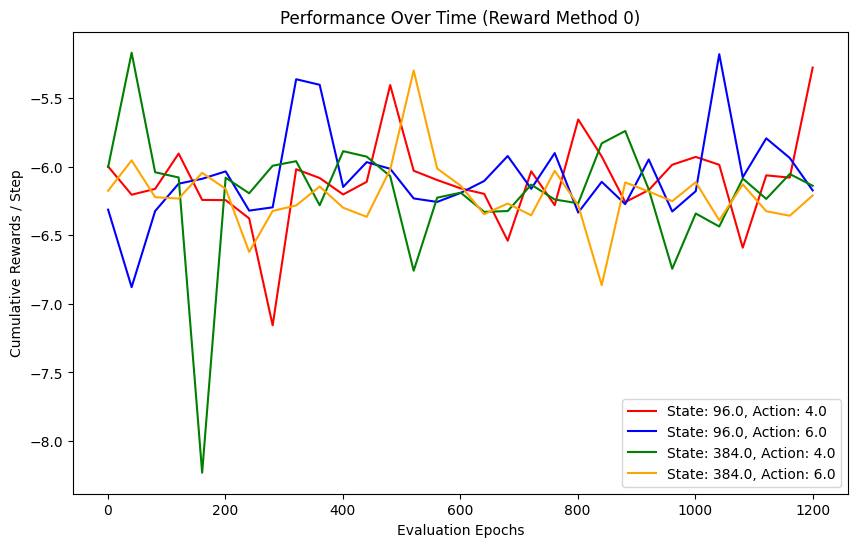

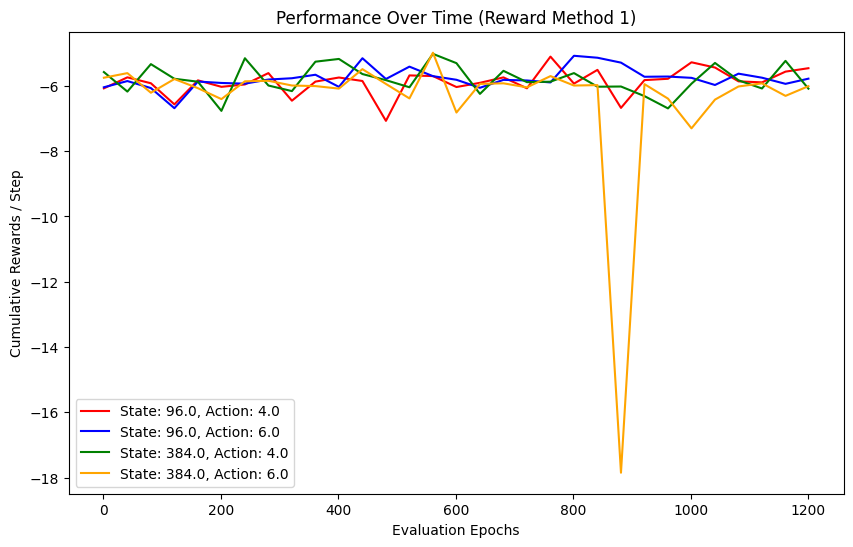

In [7]:
colors = {
    (96, 4): 'red',
    (96, 6): 'blue',
    (384, 4): 'green',
    (384, 6): 'orange'
}

# Reward methods
reward_methods = [0, 1]

for reward in reward_methods:
    plt.figure(figsize=(10, 6))

    for index, row in best_hyperparams[best_hyperparams['reward_method'] == reward].iterrows():
        state_size = row['state_size']
        action_size = row['action_size']
        lr = row['learning_rate']
        df = row['discount_factor']
        ed = row['epsilon_decay']

        # Construct the file name and load the data
        file_name = f"./Results/q-learning/lr{lr}_df{df}_ed{ed}_{int(state_size)}_{int(action_size)}_{int(reward)}.npy"
        data = np.load(file_name)

        # Plotting
        epochs = data[:, 0]
        cumulative_rewards = data[:, 1]
        plt.plot(epochs, cumulative_rewards, color=colors[(state_size, action_size)], label=f"State: {state_size}, Action: {action_size}")

    plt.xlabel("Evaluation Epochs")
    plt.ylabel("Cumulative Rewards / Step")
    plt.title(f"Performance Over Time (Reward Method {reward})")
    plt.legend()
    plt.show()

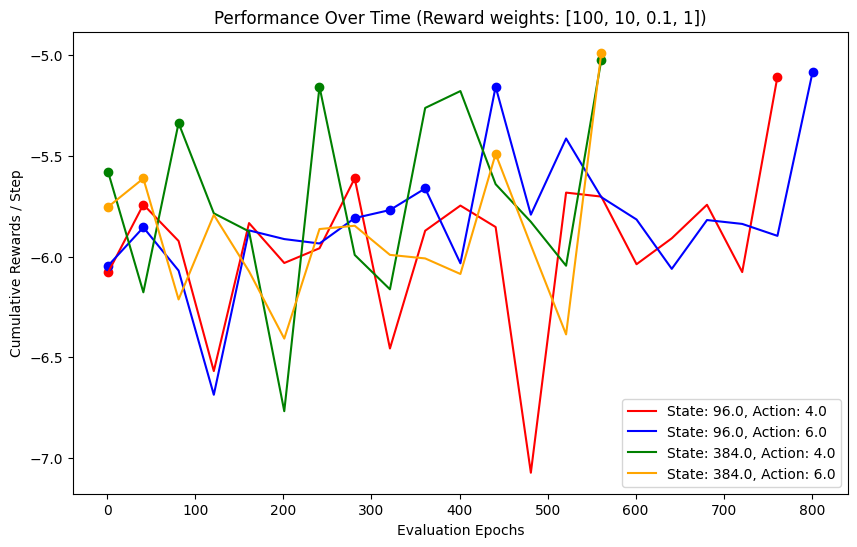

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming best_hyperparams is already defined and loaded
# Define colors for each state-action pair
colors = {
    (96, 4): 'red',
    (96, 6): 'blue',
    (384, 4): 'green',
    (384, 6): 'orange'
}

# Reward methods
reward_methods = [1]

for r in reward_methods:
    plt.figure(figsize=(10, 6))

    # Filter for reward method 0
    best_hyperparams_reward_0 = best_hyperparams[best_hyperparams['reward_method'] == 1]

    for index, row in best_hyperparams_reward_0.iterrows():
        state_size = row['state_size']
        action_size = row['action_size']
        lr = row['learning_rate']
        df = row['discount_factor']
        ed = row['epsilon_decay']
        best_performance = row['cumulative_rewards_per_step']

        # Construct the file name and load the data
        file_name = f"./Results/q-learning/lr{lr}_df{df}_ed{ed}_{int(state_size)}_{int(action_size)}_1.npy"
        data = np.load(file_name)

        # Extract epochs and cumulative rewards
        epochs = data[:, 0]
        cumulative_rewards = data[:, 1]

        # Find the epoch where the best performance is first achieved or exceeded
        target_epoch_index = np.argmax(cumulative_rewards >= best_performance)
        if cumulative_rewards[target_epoch_index] < best_performance:
            target_epoch_index = len(epochs) - 1  # Use the full range if the target is not reached

        # Plotting only up to the target_epoch_index
        plt.plot(epochs[:target_epoch_index + 1], cumulative_rewards[:target_epoch_index + 1], color=colors[(state_size, action_size)], label=f"State: {state_size}, Action: {action_size}")

        # Mark improvements
        last_best_performance = float('-inf')
        for epoch, reward in zip(epochs[:target_epoch_index + 1], cumulative_rewards[:target_epoch_index + 1]):
            if reward > last_best_performance:
                plt.scatter(epoch, reward, color=colors[(state_size, action_size)], marker='o')
                last_best_performance = reward

    plt.xlabel("Evaluation Epochs")
    plt.ylabel("Cumulative Rewards / Step")
    plt.title(f"Performance Over Time (Reward weights: [100, 10, 0.1, 1])")
    plt.legend()
    plt.show()


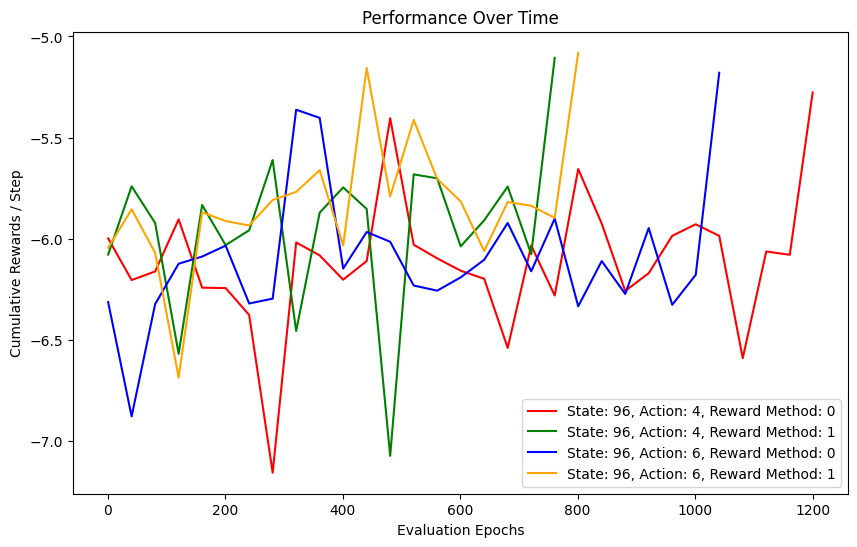

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming best_hyperparams is already defined and loaded

# Initialize the figure
plt.figure(figsize=(10, 6))

# Define colors for each combination of state-action pair and reward method
colors = {
    (96, 4, 0): 'red',
    (96, 6, 0): 'blue',
    (96, 4, 1): 'green',
    (96, 6, 1): 'orange'
}

# Define the state and action sizes to plot
state_action_pairs = [(96, 4), (96, 6)]

# Loop through each state-action pair
for state_size, action_size in state_action_pairs:
    for r in [0, 1]:  # Loop through reward methods directly
        # Filter for the specific state size, action size, and reward method
        best_hyperparams_filtered = best_hyperparams[(best_hyperparams['state_size'] == state_size) & 
                                                      (best_hyperparams['action_size'] == action_size) & 
                                                      (best_hyperparams['reward_method'] == r)]

        for index, row in best_hyperparams_filtered.iterrows():
            lr = row['learning_rate']
            df = row['discount_factor']
            ed = row['epsilon_decay']
            best_performance = row['cumulative_rewards_per_step']

            # Construct the file name and load the data
            file_name = f"./Results/q-learning/lr{lr}_df{df}_ed{ed}_{int(state_size)}_{int(action_size)}_{r}.npy"
            data = np.load(file_name)

            # Extract epochs and cumulative rewards
            epochs = data[:, 0]
            cumulative_rewards = data[:, 1]

            # Find the epoch where the best performance is first achieved or exceeded
            target_epoch_index = np.argmax(cumulative_rewards >= best_performance)
            if cumulative_rewards[target_epoch_index] < best_performance:
                target_epoch_index = len(epochs) - 1  # Use the full range if the target is not reached

            # Plotting only up to the target_epoch_index
            plt.plot(epochs[:target_epoch_index + 1], cumulative_rewards[:target_epoch_index + 1], color=colors[(state_size, action_size, r)], label=f"State: {state_size}, Action: {action_size}, Reward Method: {r}")

            # Optionally mark improvements - omitted for clarity

# Finalize the plot
plt.xlabel("Evaluation Epochs")
plt.ylabel("Cumulative Rewards / Step")
plt.title("Performance Over Time")
plt.legend()
plt.show()


In [ ]:
Running training 5/8 with learning rate=0.01, discount factor=0.85, epsilon decay=0.995. state size=96, Action siz=4
Running training 2/8 with learning rate=0.05, discount factor=0.85, epsilon decay=0.99. state size=384, Action siz=4